# Training from energy

This notebook walks you through training a normalizing flow by gradient descent when data is unavailable, but you have access to an energy function $U(x)$ proportional to the density $p(x)$.

In [1]:
import matplotlib.pyplot as plt
import torch
import zuko

## Energy

We consider a simple multi-modal energy function.

$$ \log U(x) = -2 \big( x_1^2 + x_2^2 - 2 \big)^2 - \sin(\pi x_1) $$

In [2]:
def log_energy(x):
    x1, x2 = x[..., 0], x[..., 1]
    return -2 * (x1 ** 2 + x2 ** 2 - 2) ** 2 - torch.sin(torch.pi * x1)

In [3]:
x1 = torch.linspace(-3, 3, 64)
x2 = torch.linspace(-3, 3, 64)

x = torch.stack(torch.meshgrid(x1, x2, indexing='xy'), dim=-1)

energy = log_energy(x).exp()

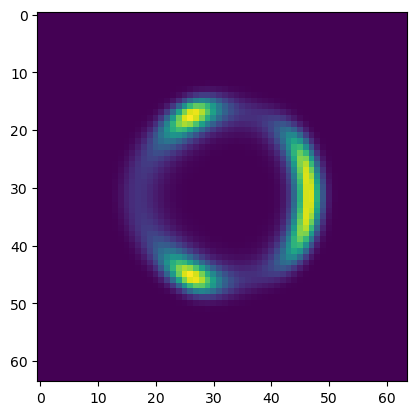

In [4]:
plt.figure(figsize=(4.8, 4.8))
plt.imshow(energy)
plt.show()

## Flow

We use a neural spline flow (NSF) as density estimator $q_\phi(x)$. However, we inverse the transformation(s), which makes sampling more efficient as the inverse call of an autoregressive transformation is $D$ (where $D$ is the number of features) times slower than its forward call.

In [5]:
flow = zuko.flows.NSF(features=2, transforms=3, hidden_features=(64, 64))
flow = zuko.flows.Flow(flow.transform.inv, flow.base)
flow

Flow(
  (transform): LazyInverse(
    (transform): LazyComposedTransform(
      (0): MaskedAutoregressiveTransform(
        (base): MonotonicRQSTransform(bins=8)
        (order): [0, 1]
        (hyper): MaskedMLP(
          (0): MaskedLinear(in_features=2, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=46, bias=True)
        )
      )
      (1): MaskedAutoregressiveTransform(
        (base): MonotonicRQSTransform(bins=8)
        (order): [1, 0]
        (hyper): MaskedMLP(
          (0): MaskedLinear(in_features=2, out_features=64, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=64, out_features=64, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=64, out_features=46, bias=True)
        )
      )
      (2): MaskedAutoregressiveTransform(
        (base): MonotonicRQSTransform(bins=8)
    

The objective is to minimize the Kullback-Leibler (KL) divergence between the modeled distribution $q_\phi(x)$ and the true data distribution $p(x)$.

$$
    \begin{align}
        \arg \min_\phi & ~ \mathrm{KL} \big( q_\phi(x) || p(x) \big) \\
        = \arg \min_\phi & ~ \mathbb{E}_{q_\phi(x)} \left[ \log \frac{q_\phi(x)}{p(x)} \right] \\
        = \arg \min_\phi & ~ \mathbb{E}_{q_\phi(x)} \big[ \log q_\phi(x) - \log U(x) \big]
    \end{align}
$$

For this purpose, [`NormalizingFlow`](zuko.distributions.NormalizingFlow) objects implement a special `rsample_and_log_prob` method which is much faster than calling `rsample` and `log_prob` separately.

In [6]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

for epoch in range(8):
    losses = []

    for _ in range(256):
        x, log_prob = flow().rsample_and_log_prob((256,))

        loss = log_prob.mean() - log_energy(x).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    print(f'({epoch})', losses.mean().item(), '±', losses.std().item())

(0) -0.9997022151947021 ± 1.268591284751892
(1) -1.55545973777771 ± 0.06887820363044739
(2) -1.5759055614471436 ± 0.024518314749002457
(3) -1.551119327545166 ± 0.31484392285346985
(4) -1.5432345867156982 ± 0.4345369040966034
(5) -1.583936333656311 ± 0.018940608948469162
(6) -1.5850251913070679 ± 0.02267366833984852
(7) -1.5866143703460693 ± 0.017558354884386063


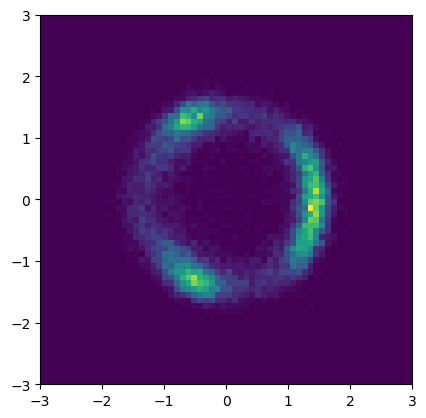

In [7]:
samples = flow().sample((16384,))

plt.figure(figsize=(4.8, 4.8))
plt.hist2d(*samples.T, bins=64, range=((-3, 3), (-3, 3)))
plt.show()

Note that this "reverse KL" objective is prone to mode collapses, especially in high-dimension.